Extends mean-variance procedure to account for risky liabilities.

Optimal Weights: [1.   0.   0.   0.32 0.59 0.08]
Expected Return: 0.78 %
Risk (Standard Deviation): 2.52 %


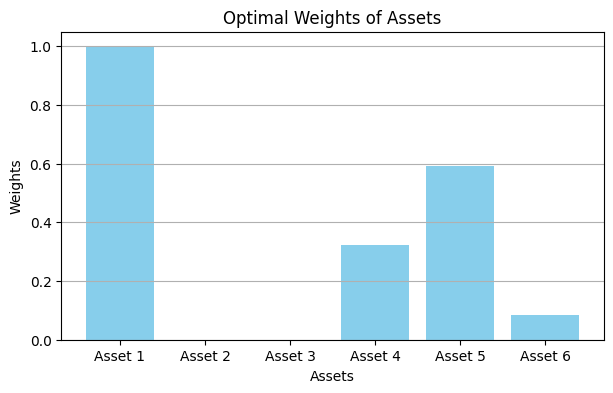

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Start of inputs
risk_free_rate = 0.005  # Risk-free rate
expected_returns = np.array([0.5+10/12, 0.0, 0.0, -7/12, -0.21-4/12, -0.16-4/12])  # GEL USD EUR Expected returns [0.10, 0.09, 0.08, -0.06, -0.05, -0.04]
# Standard deviations for the assets:
std_devs = np.array([2.87, 0.05, 0.05, 0, 2.36, 2.62])
# correlations:
correlation_matrix_tiangular = np.array([
    #a1,a1,a3,GEL,USD,EUR
    [1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [-.49, 0, 0, 0, 1, 0],
    [-.30, 0, 0, 0, 0.66, 1]
])
#end of inputs

correlation_matrix = correlation_matrix_tiangular+np.transpose(correlation_matrix_tiangular)-np.diag(np.diagonal(correlation_matrix_tiangular))
cov_matrix = np.outer(std_devs, std_devs) * correlation_matrix

# Function to calculate portfolio performance
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std_dev

# Function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, expected_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev #შარპის წილადი
    return -sharpe_ratio  # We minimize the negative Sharpe Ratio

# Portfolio optimization function with custom constraints
def optimize_portfolio(expected_returns, cov_matrix, risk_free_rate):
    num_assets = len(expected_returns)
    bounds = tuple((0, 1) for asset in range(num_assets))  # Allow weights between 0 and 1
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x[:3]) - 1},  # First 3 assets sum to 1
        {'type': 'eq', 'fun': lambda x: np.sum(x[3:]) - 1}   # Last 3 assets sum to 1
    ]
    initial_guess = num_assets * [0.5]  # Initial guess

    result = minimize(negative_sharpe_ratio, initial_guess, 
                      args=(expected_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Run the optimization
result = optimize_portfolio(expected_returns, cov_matrix, risk_free_rate)

# Print the results
optimal_weights = result.x
optimal_return, optimal_risk = portfolio_performance(optimal_weights, expected_returns, cov_matrix)

print("Optimal Weights:", np.round(optimal_weights,2))
print("Expected Return:", np.round(optimal_return,2),'%')
print("Risk (Standard Deviation):", np.round(optimal_risk,2),'%')


#წონების ბარი
# Asset labels
asset_labels = [f'Asset {i+1}' for i in range(len(optimal_weights))]

# Create a bar chart
plt.figure(figsize=(7, 4))
plt.bar(asset_labels, optimal_weights, color='skyblue')
plt.title('Optimal Weights of Assets')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.grid(axis='y')

# Show the plot
plt.show()

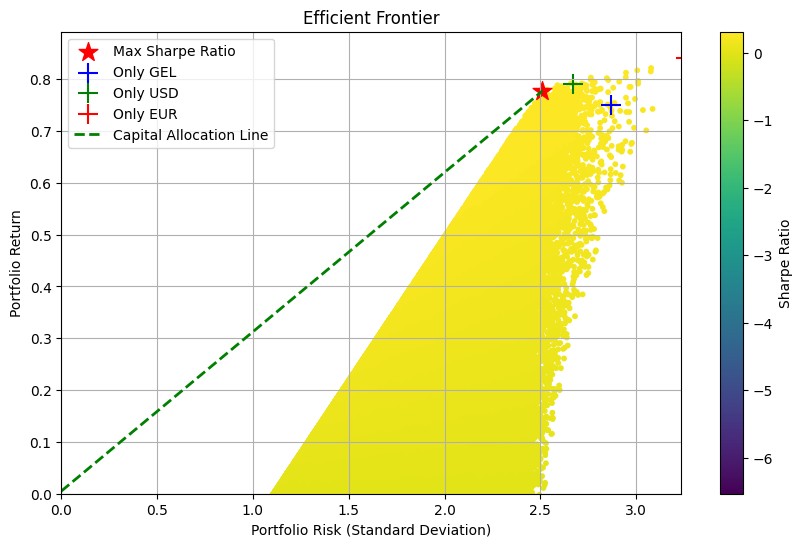

In [2]:
import pandas as pd

# Generate efficient frontier
num_portfolios = 1000000
results = np.zeros((3, num_portfolios))  # Return, Risk, Sharpe Ratio

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights[:3] /= np.sum(weights[:3])  # Normalize assets to sum to 1
    weights[3:] /= np.sum(weights[3:])  # Normalize laibilities to sum to 1
    portfolio_return, portfolio_std_dev = portfolio_performance(weights, expected_returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Sharpe Ratio

# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe Ratio'])

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.grid()

plt.ylim(bottom=0)
plt.xlim(left=0)

# Highlight the maximum Sharpe ratio portfolio
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
max_sharpe_return = results_df['Return'][max_sharpe_idx]
max_sharpe_risk = results_df['Risk'][max_sharpe_idx]
plt.scatter(results_df['Risk'][max_sharpe_idx], results_df['Return'][max_sharpe_idx], color='red', marker='*', s=200, label='Max Sharpe Ratio')

# Only GEL portfolio
plt.scatter(2.87,0.75, color='blue', marker='+', s=200, label='Only GEL')
# Only USD portfolio
plt.scatter( 2.67,.79, color='green', marker='+', s=200, label='Only USD')
# Only EUR portfolio
plt.scatter(  3.26,0.84, color='red', marker='+', s=200, label='Only EUR')

# Add the CAL
cal_x = [0, max_sharpe_risk]
cal_y = [risk_free_rate, max_sharpe_return]
plt.plot(cal_x, cal_y, color='green', linestyle='--', linewidth=2, label='Capital Allocation Line')

plt.legend()
plt.show()